In [2]:
# 필수 라이브러리 설치
!pip install torchaudio
!pip install matplotlib
!pip install librosa  # 추가적인 오디오 처리용

# 라이브러리 임포트
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

In [5]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 드라이브에서 압축 파일 경로
zip_path = '/content/drive/MyDrive/Colab Notebooks/audio_dataset.zip'

# 압축 해제할 위치
extract_path = '/content/audio_data'

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 압축 해제된 파일 확인
audio_files = os.listdir(extract_path)
print("압축 해제된 파일들:", audio_files)

# m4a 파일만 필터링 (mp4a가 아니라 m4a)
m4a_files = [f for f in audio_files if f.endswith('.m4a')]
print(f"m4a 파일들 ({len(m4a_files)}개):", m4a_files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
압축 해제된 파일들: ['095522039.m4a', '095522042.m4a', '095522041.m4a', '095522040.m4a']
m4a 파일들 (4개): ['095522039.m4a', '095522042.m4a', '095522041.m4a', '095522040.m4a']


In [6]:
# 오디오 파일 로드 및 정보 확인 (첫 번째 링크의 예제 참고)
print("=== 오디오 파일 정보 ===")
for i, audio_file in enumerate(m4a_files, 1):
    file_path = os.path.join(extract_path, audio_file)
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        print(f"{i}. 파일: {audio_file}")
        print(f"   파형 크기: {waveform.shape}")  # [채널수, 샘플수]
        print(f"   샘플링 레이트: {sample_rate} Hz")
        print(f"   재생 시간: {waveform.shape[1] / sample_rate:.2f}초")
        print("-" * 50)
    except Exception as e:
        print(f"파일 로드 오류 ({audio_file}): {e}")

=== 오디오 파일 정보 ===
1. 파일: 095522039.m4a
   파형 크기: torch.Size([1, 177152])
   샘플링 레이트: 44100 Hz
   재생 시간: 4.02초
--------------------------------------------------
2. 파일: 095522042.m4a
   파형 크기: torch.Size([1, 177152])
   샘플링 레이트: 44100 Hz
   재생 시간: 4.02초
--------------------------------------------------
3. 파일: 095522041.m4a
   파형 크기: torch.Size([1, 177152])
   샘플링 레이트: 44100 Hz
   재생 시간: 4.02초
--------------------------------------------------
4. 파일: 095522040.m4a
   파형 크기: torch.Size([1, 177152])
   샘플링 레이트: 44100 Hz
   재생 시간: 4.02초
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [7]:
# 파형 시각화 함수
def plot_waveform(waveform, sample_rate, title="Waveform"):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    plt.figure(figsize=(15, 6))
    for c in range(num_channels):
        plt.subplot(num_channels, 1, c + 1)
        plt.plot(time_axis, waveform[c], linewidth=0.8)
        plt.title(f"{title} - Channel {c + 1}")
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

print("파형 시각화 함수 정의 완료")

파형 시각화 함수 정의 완료


=== 파형(Waveform) 시각화 ===


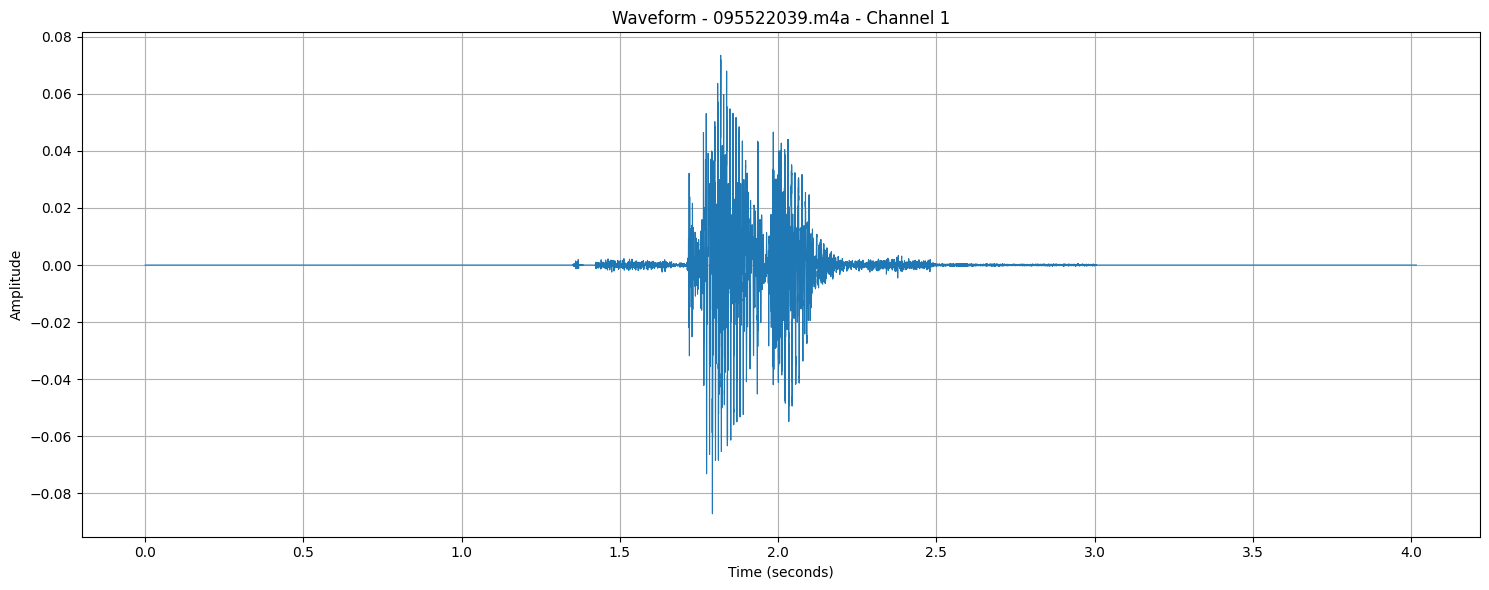

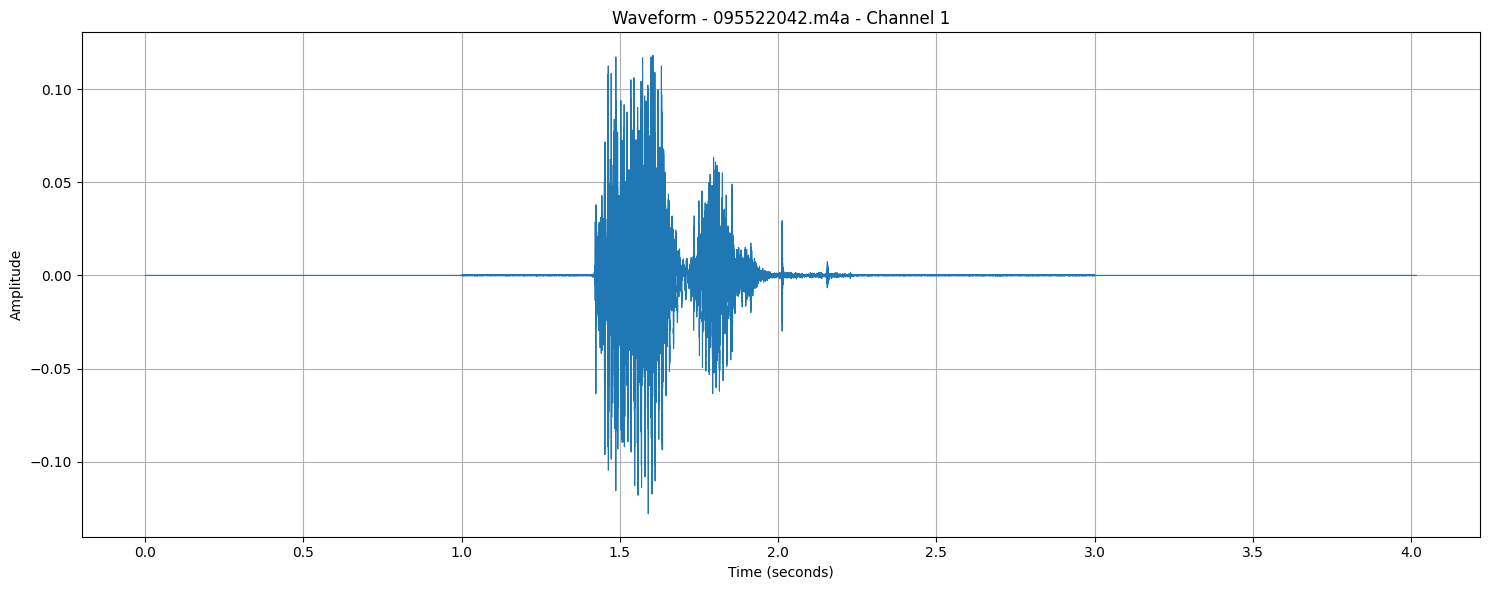

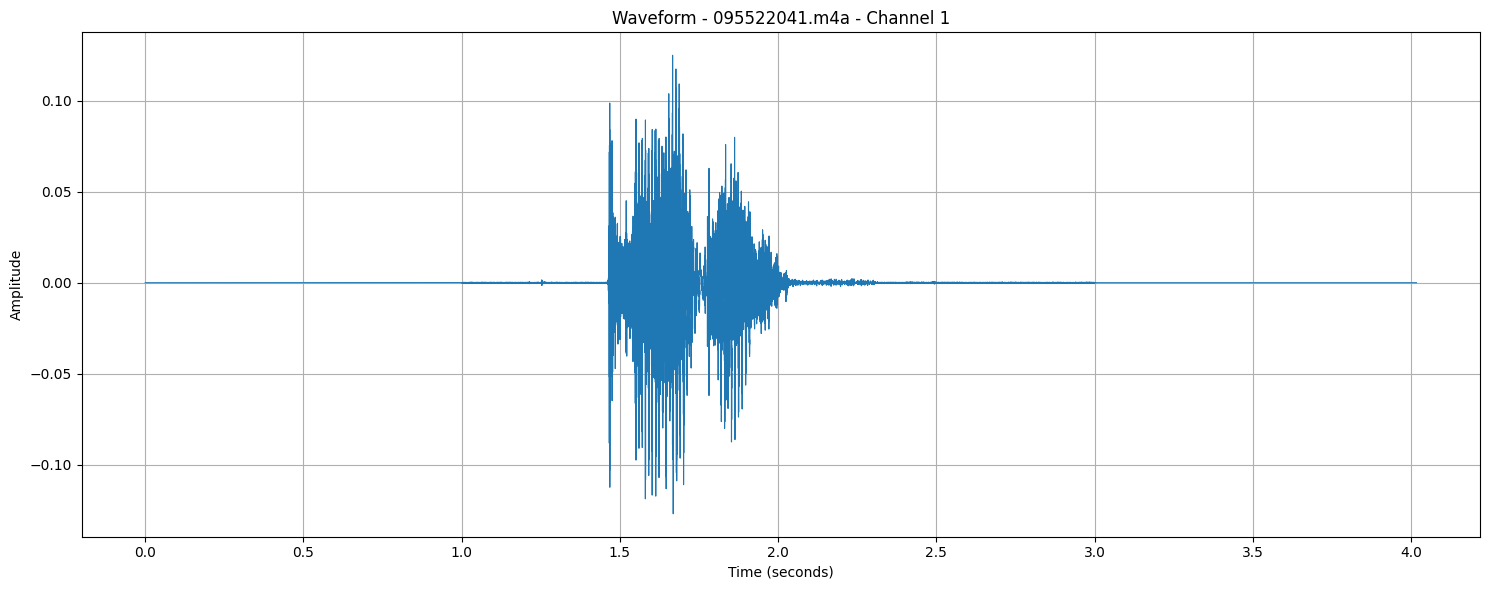

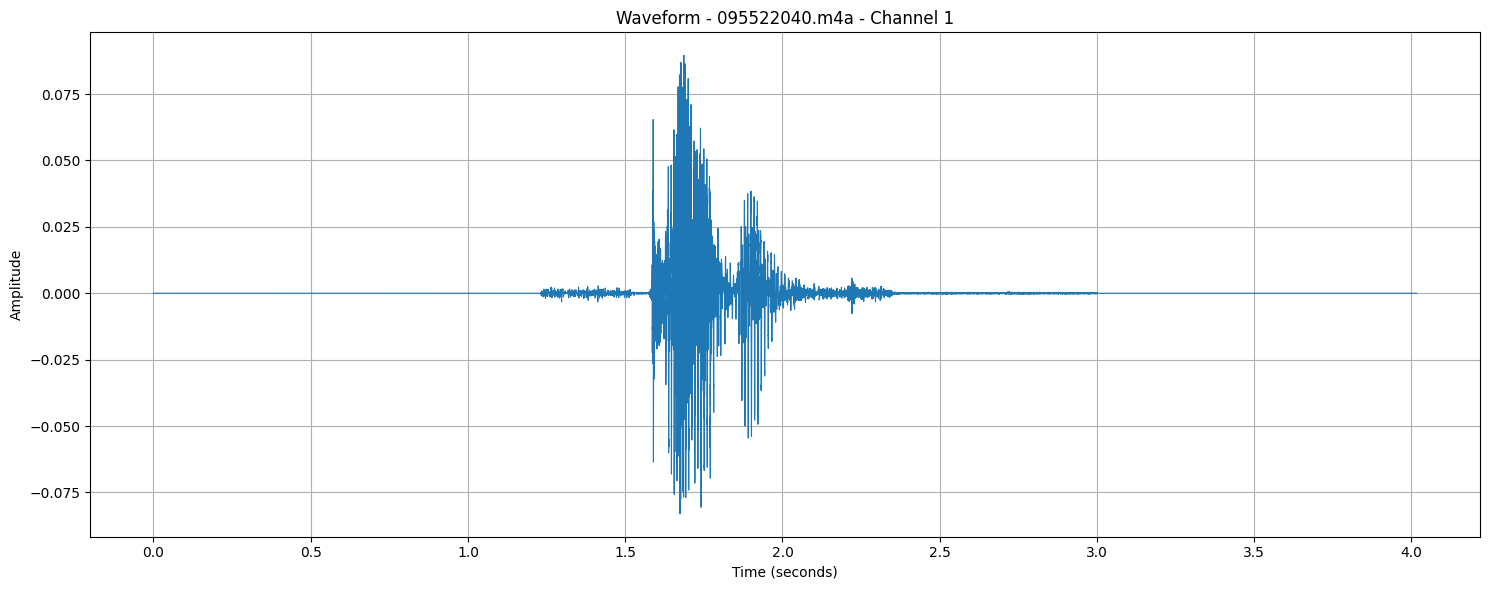

In [8]:
# 각 m4a 파일의 파형 출력
print("=== 파형(Waveform) 시각화 ===")
for audio_file in m4a_files:
    file_path = os.path.join(extract_path, audio_file)
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        plot_waveform(waveform, sample_rate, f"Waveform - {audio_file}")
    except Exception as e:
        print(f"파형 시각화 오류 ({audio_file}): {e}")

In [10]:
# 스펙트로그램 시각화 함수
def plot_spectrogram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    # 첫 번째 채널만 사용 (스테레오인 경우)
    if waveform.shape[0] > 1:
        waveform = waveform[0:1]

    # STFT를 사용한 스펙트로그램 생성
    spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=1024,
        hop_length=512,
        power=2.0
    )
    spectrogram = spectrogram_transform(torch.tensor(waveform))

    plt.figure(figsize=(15, 8))
    plt.imshow(
        spectrogram[0].log2().numpy(),
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )
    plt.title(title)
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')
    plt.colorbar(label='Log Power')
    plt.show()

print("스펙트로그램 시각화 함수 정의 완료")

스펙트로그램 시각화 함수 정의 완료


=== 스펙트로그램(Spectrogram) 시각화 ===


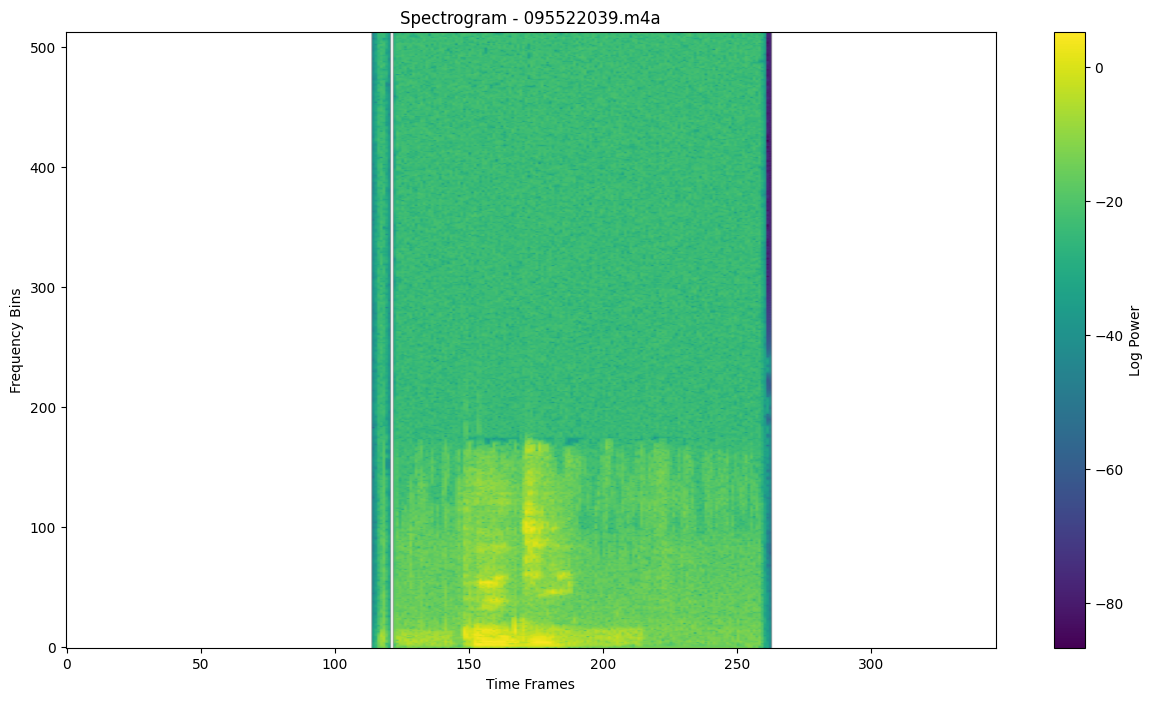

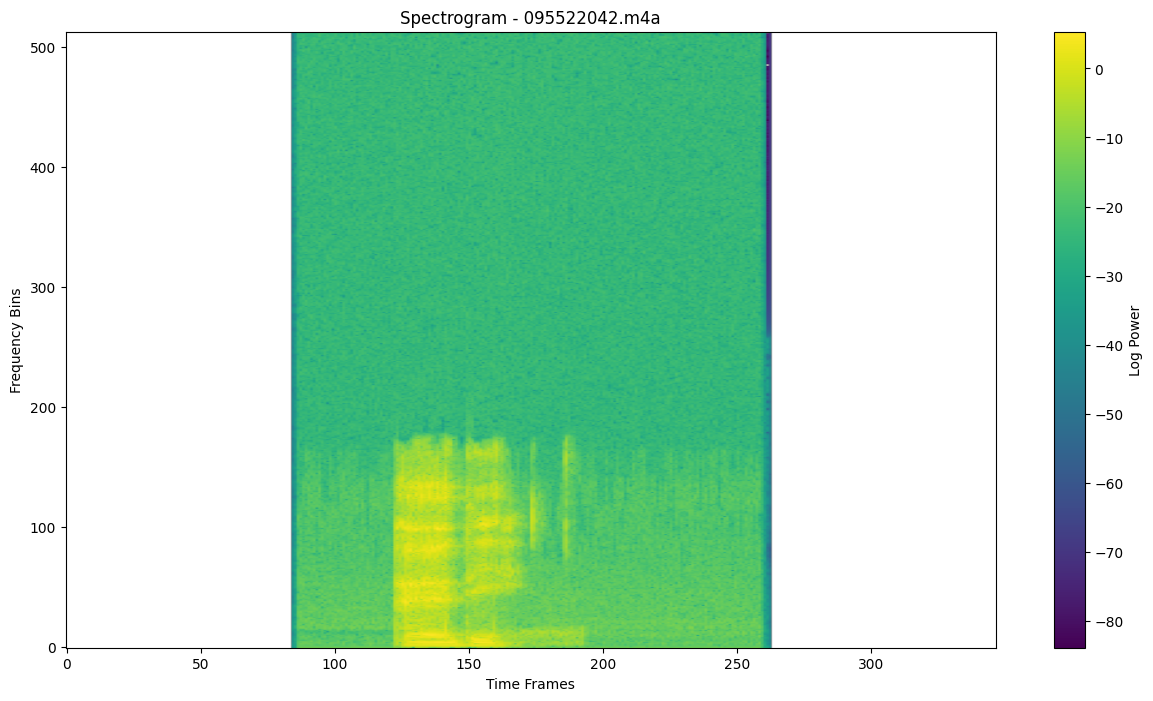

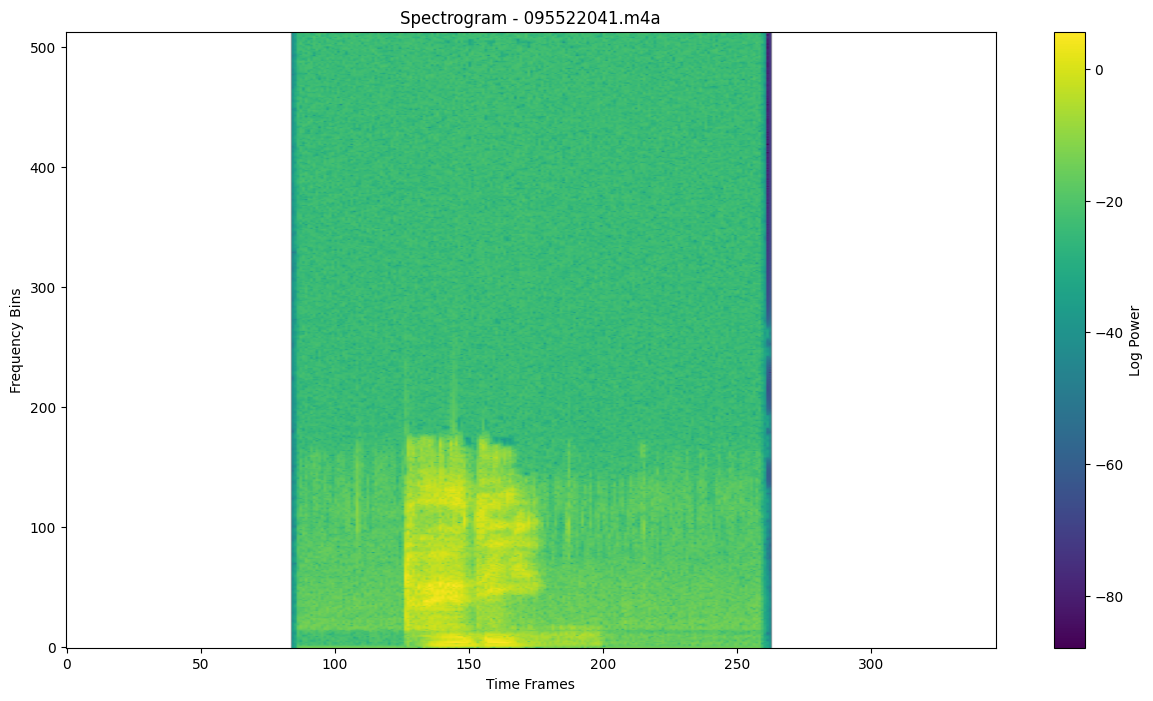

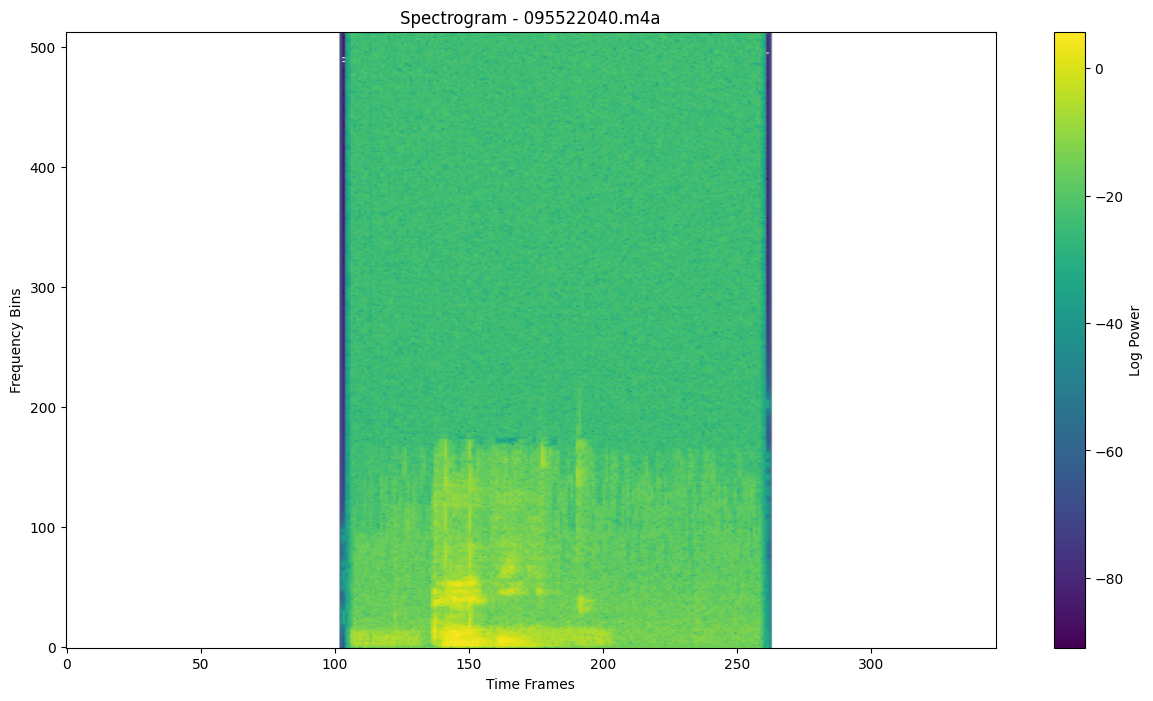

In [11]:
# 각 m4a 파일의 스펙트로그램 출력
print("=== 스펙트로그램(Spectrogram) 시각화 ===")
for audio_file in m4a_files:
    file_path = os.path.join(extract_path, audio_file)
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        plot_spectrogram(waveform, sample_rate, f"Spectrogram - {audio_file}")
    except Exception as e:
        print(f"스펙트로그램 시각화 오류 ({audio_file}): {e}")

In [12]:
# 리샘플링 함수 (두 번째 링크의 예제 참고)
def resample_audio(waveform, orig_freq, new_freq):
    resampler = torchaudio.transforms.Resample(orig_freq, new_freq)
    resampled_waveform = resampler(waveform)
    return resampled_waveform

# 리샘플링 비교 시각화 함수
def compare_resampling(original, downsampled, upsampled, orig_sr, down_sr, up_sr, filename):
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    # 원본
    time_orig = torch.arange(0, original.shape[1]) / orig_sr
    axes[0].plot(time_orig, original[0].numpy(), linewidth=0.8, color='blue')
    axes[0].set_title(f'Original - {filename} (SR: {orig_sr} Hz)')
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True)

    # 다운샘플링
    time_down = torch.arange(0, downsampled.shape[1]) / down_sr
    axes[1].plot(time_down, downsampled[0].numpy(), linewidth=0.8, color='red')
    axes[1].set_title(f'Downsampled (SR: {down_sr} Hz)')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True)

    # 업샘플링
    time_up = torch.arange(0, upsampled.shape[1]) / up_sr
    axes[2].plot(time_up, upsampled[0].numpy(), linewidth=0.8, color='green')
    axes[2].set_title(f'Upsampled (SR: {up_sr} Hz)')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Amplitude')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

print("리샘플링 함수 정의 완료")

리샘플링 함수 정의 완료


=== 리샘플링(Resampling) 실습 ===

파일: 095522039.m4a
원본: torch.Size([1, 177152]) (SR: 44100 Hz)
다운샘플링: torch.Size([1, 88576]) (SR: 22050 Hz)
업샘플링: torch.Size([1, 354304]) (SR: 88200 Hz)


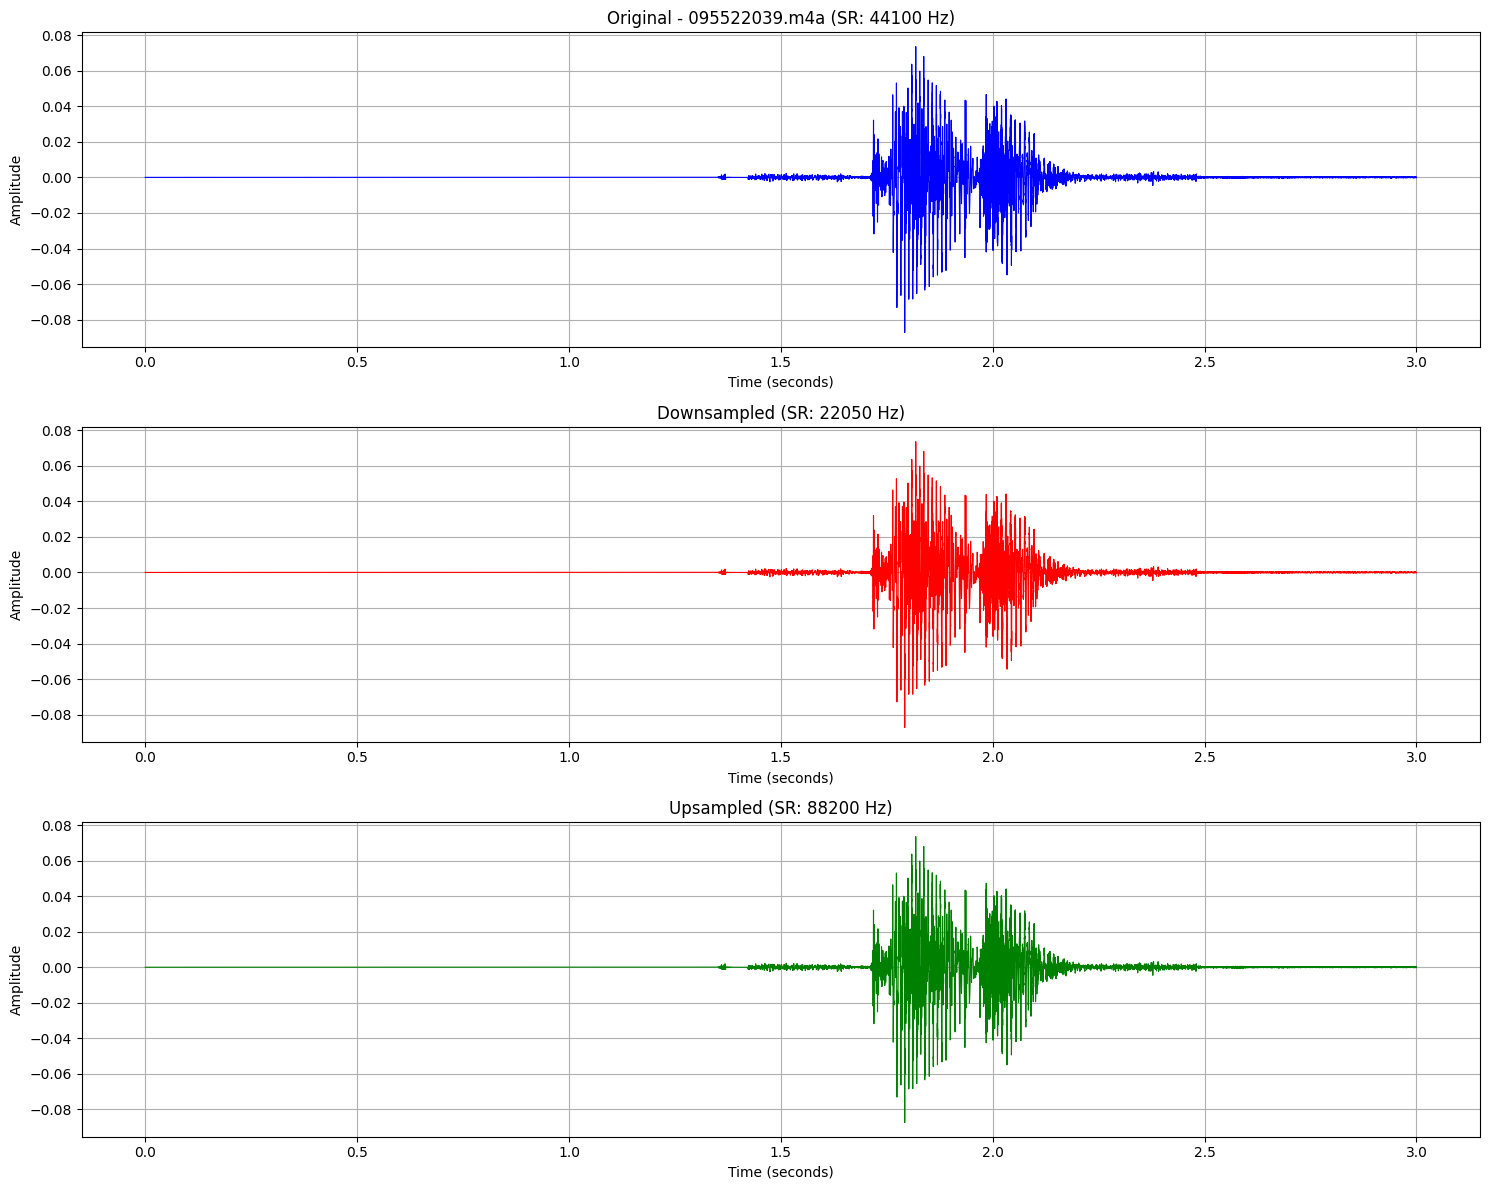


파일: 095522042.m4a
원본: torch.Size([1, 177152]) (SR: 44100 Hz)
다운샘플링: torch.Size([1, 88576]) (SR: 22050 Hz)
업샘플링: torch.Size([1, 354304]) (SR: 88200 Hz)


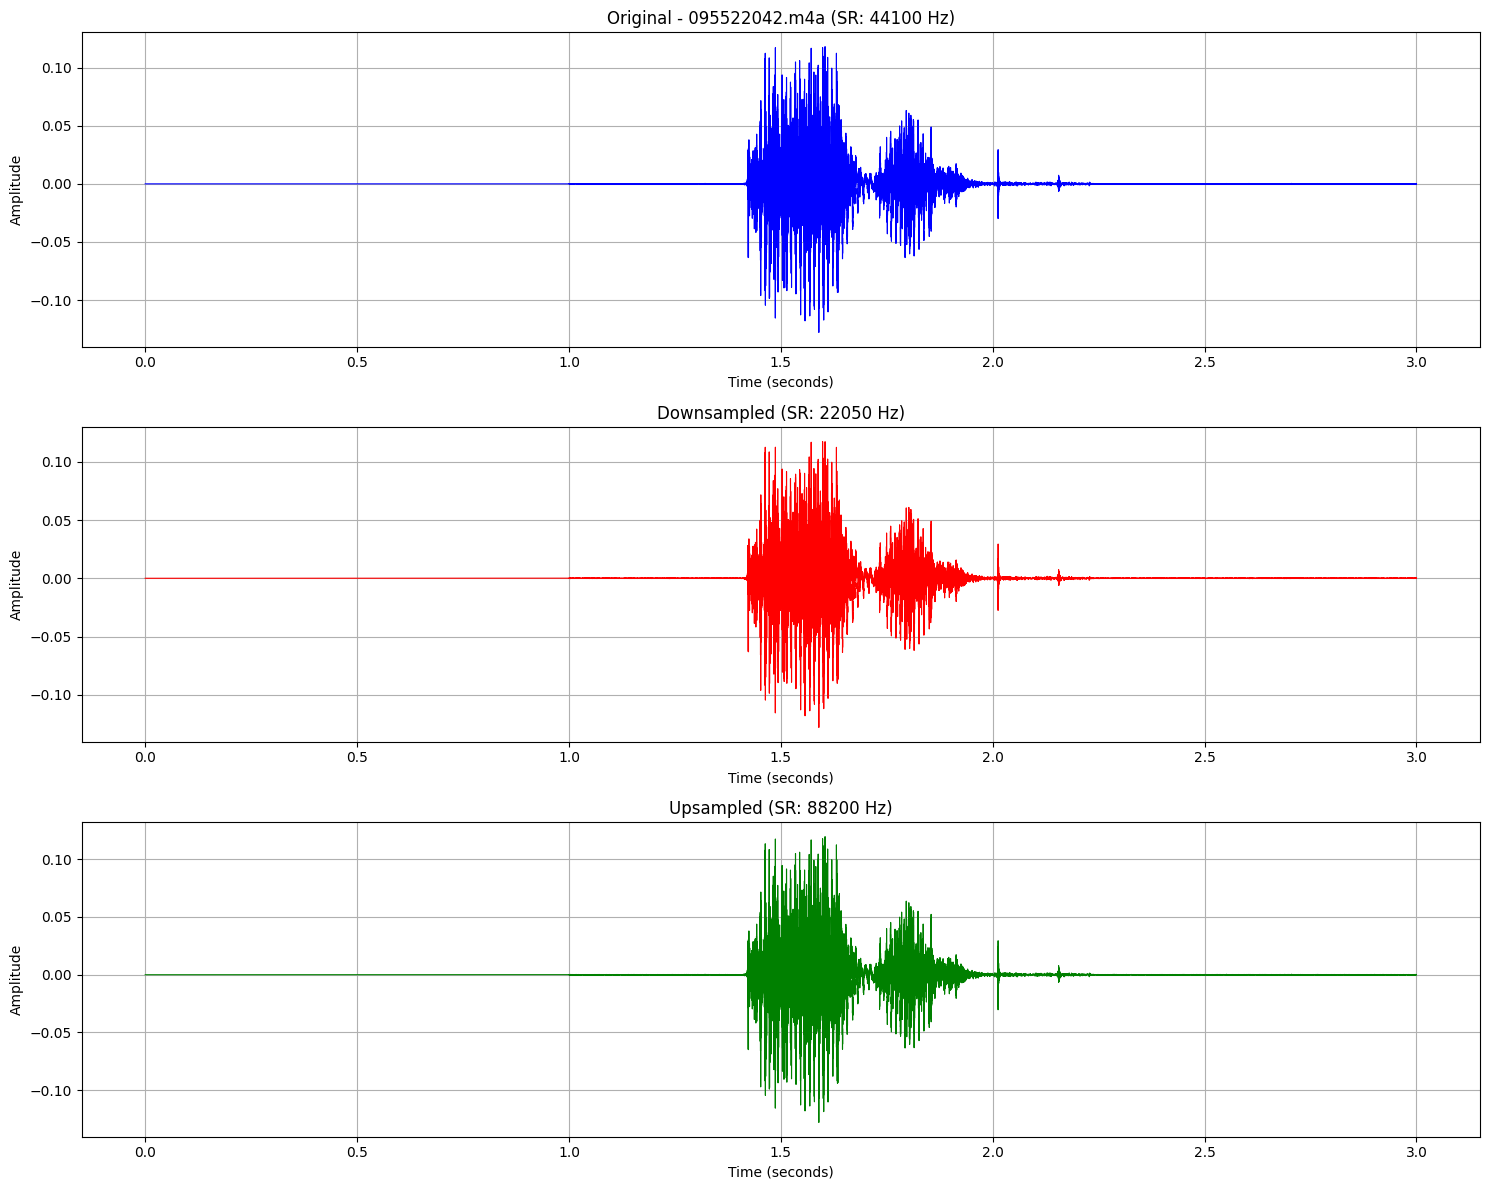


파일: 095522041.m4a
원본: torch.Size([1, 177152]) (SR: 44100 Hz)
다운샘플링: torch.Size([1, 88576]) (SR: 22050 Hz)
업샘플링: torch.Size([1, 354304]) (SR: 88200 Hz)


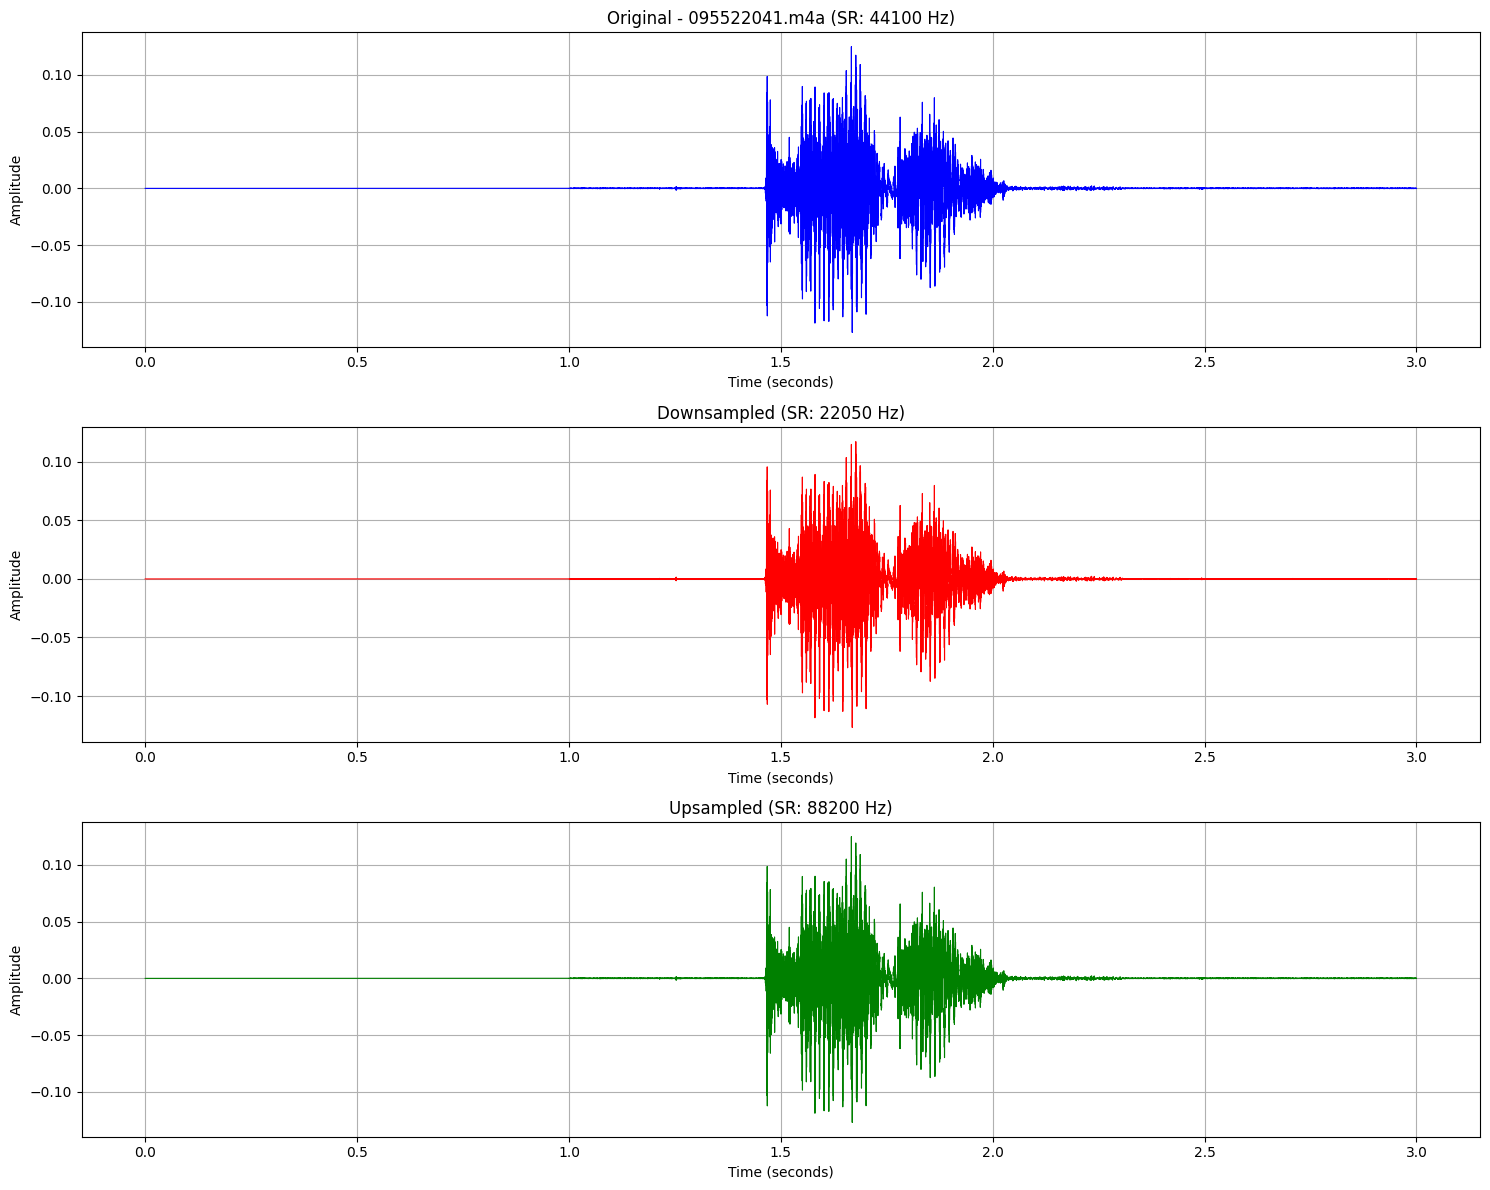


파일: 095522040.m4a
원본: torch.Size([1, 177152]) (SR: 44100 Hz)
다운샘플링: torch.Size([1, 88576]) (SR: 22050 Hz)
업샘플링: torch.Size([1, 354304]) (SR: 88200 Hz)


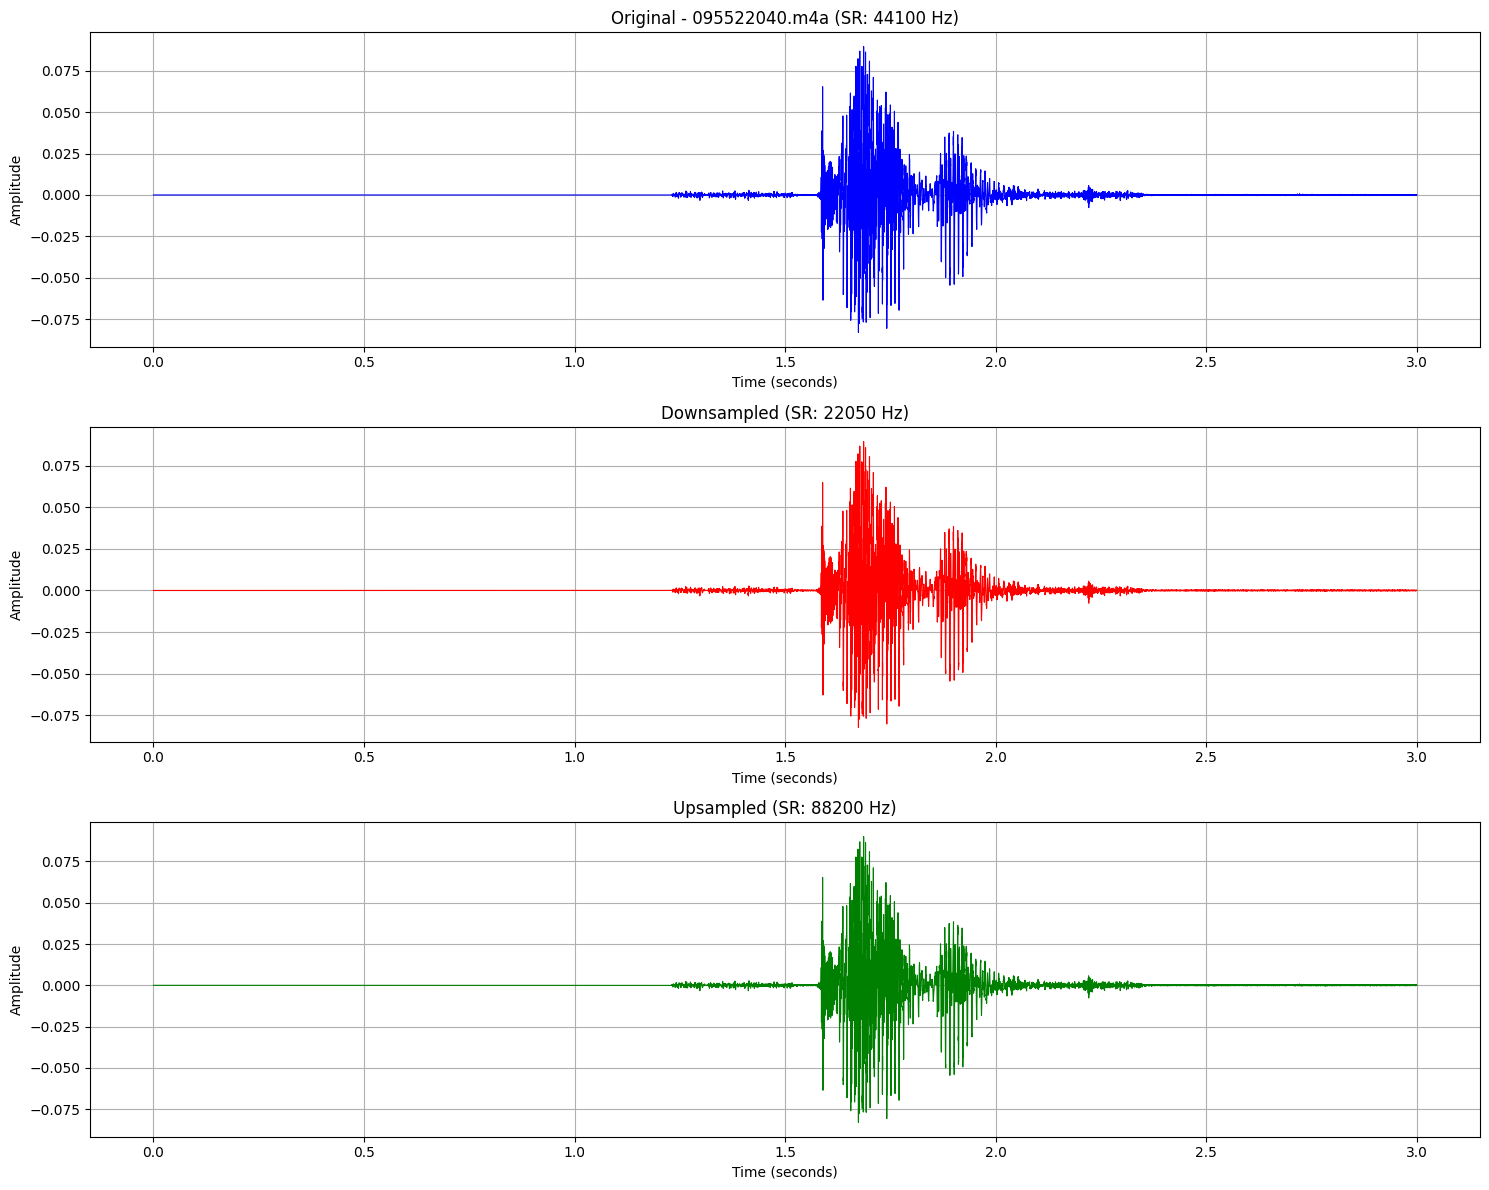

In [13]:
# 다운샘플링과 업샘플링 실습
print("=== 리샘플링(Resampling) 실습 ===")
for audio_file in m4a_files:
    file_path = os.path.join(extract_path, audio_file)
    try:
        waveform, sample_rate = torchaudio.load(file_path)

        # 다운샘플링 (예: 절반으로 감소)
        down_sr = sample_rate // 2
        downsampled = resample_audio(waveform, sample_rate, down_sr)

        # 업샘플링 (예: 2배로 증가)
        up_sr = sample_rate * 2
        upsampled = resample_audio(waveform, sample_rate, up_sr)

        print(f"\n파일: {audio_file}")
        print(f"원본: {waveform.shape} (SR: {sample_rate} Hz)")
        print(f"다운샘플링: {downsampled.shape} (SR: {down_sr} Hz)")
        print(f"업샘플링: {upsampled.shape} (SR: {up_sr} Hz)")

        # 시각화 비교 (첫 3초만)
        max_samples_orig = min(waveform.shape[1], sample_rate * 3)
        max_samples_down = min(downsampled.shape[1], down_sr * 3)
        max_samples_up = min(upsampled.shape[1], up_sr * 3)

        compare_resampling(
            waveform[:, :max_samples_orig],
            downsampled[:, :max_samples_down],
            upsampled[:, :max_samples_up],
            sample_rate, down_sr, up_sr, audio_file
        )

    except Exception as e:
        print(f"리샘플링 오류 ({audio_file}): {e}")

In [14]:
# 실습 결과 요약
print("\n" + "="*60)
print("             LAB-Audio-01 실습 완료 요약")
print("="*60)
print(f"✓ 처리한 m4a 파일 수: {len(m4a_files)}개")
print("✓ 완료된 작업:")
print("  - 오디오 파일 로드 및 정보 확인")
print("  - 파형(Waveform) 시각화")
print("  - 스펙트로그램(Spectrogram) 생성 및 시각화")
print("  - 다운샘플링 및 업샘플링 실습")
print("\n✓ 사용된 PyTorch Audio 기능:")
print("  - torchaudio.load()")
print("  - torchaudio.transforms.Spectrogram()")
print("  - torchaudio.transforms.Resample()")
print("\n✓ GitHub 제출 준비:")
print("  - 코랩 노트북 파일(.ipynb) 다운로드")
print("  - GitHub 저장소에 커밋 및 푸시")
print("="*60)

# 파일별 처리 결과 출력
print("\n처리된 파일 목록:")
for i, audio_file in enumerate(m4a_files, 1):
    print(f"{i}. {audio_file}")


             LAB-Audio-01 실습 완료 요약
✓ 처리한 m4a 파일 수: 4개
✓ 완료된 작업:
  - 오디오 파일 로드 및 정보 확인
  - 파형(Waveform) 시각화
  - 스펙트로그램(Spectrogram) 생성 및 시각화
  - 다운샘플링 및 업샘플링 실습

✓ 사용된 PyTorch Audio 기능:
  - torchaudio.load()
  - torchaudio.transforms.Spectrogram()
  - torchaudio.transforms.Resample()

✓ GitHub 제출 준비:
  - 코랩 노트북 파일(.ipynb) 다운로드
  - GitHub 저장소에 커밋 및 푸시

처리된 파일 목록:
1. 095522039.m4a
2. 095522042.m4a
3. 095522041.m4a
4. 095522040.m4a
